 # Sentiment Analysis with LSTM/GRU Models

## Imports and Prerequisites

In [ ]:
print('\nQuietly installing  torchtext==0.10.0 and en_core_web_sm\n')

!pip install torchtext==0.10.0 --quiet
!python -m spacy download en_core_web_sm --quiet
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from nltk.tokenize import word_tokenize,TweetTokenizer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import torch.nn.functional as nnf
from sklearn.metrics import roc_curve,classification_report,auc
from sklearn.preprocessing import label_binarize
from numpy import interp
from itertools import cycle
from torchtext import vocab
from torchtext.legacy.data import Field,LabelField,BucketIterator,TabularDataset
import warnings
import spacy
import nltk
import os
import random

## Helper Functions

In [ ]:
#function removeSpecialChars to remove all special characters from text
def removeSpecialChars(text):

    text = re.sub(r'[^a-zA-z0-9\s]','',text)
    return text

#function transform to clean all data from reviews column
def transform(data):

    data = data.str.lower()
    data = data.apply(lambda x:''.join([i for i in x if i not in string.punctuation])) #remove !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    data = data.apply(removeSpecialChars)
    data = data.apply(lambda x: re.compile(r'<[^>]+>').sub('', x))

    return data

#make ratings binary with 0 being negative and 1 being positive
def ratingToInt(data) :

  data['rating'] = data['rating'].replace([1.0, 2.0,3.0,4.0], 0)
  data['rating'] = data['rating'].replace([7.0,8.0,9.0,10.0], 1)
  return data

#make item 1-dimensional
def to1D(item) :

  temp = [[item[i][0],item[i][1],item[i][2]].index(max([item[i][0],item[i][1],item[i][2]]))for i in range(len(item))]
  return temp


## Data filtering and Tokenization

In [ ]:
#filter datasets , call function transform , ratingtoInt , tokenize reviews column  , make Tabular datasets and rerurt a BucketIterator for training and validation
def filteringData(trainingData, validationData) :

  trainingData['review'] = transform(trainingData['review'])
  validationData['review'] = transform(validationData['review'])
  trainingData = ratingToInt(trainingData)
  validationData = ratingToInt(validationData)

  trainingData.to_csv('training.csv',index = False)
  validationData.to_csv('validation.csv',index = False)

  spacyResult = spacy.load('en_core_web_sm')
  #tokenize reviews column
  def tokenizer(text):
    return [w.text for w in spacyResult.tokenizer(text)]

#create field and label
  review = Field(tokenize = tokenizer, lower = True)
  label = LabelField(dtype = torch.long)
  fields = [('Text', review), ('Label', label)]
  training,validation = TabularDataset.splits(path="", train ='training.csv',validation = 'validation.csv',format = 'csv',skip_header = True,fields = fields)
  glove = vocab.Vectors(glove6btxtPath,"OUT")

  review.build_vocab(training,vectors = glove)
  label.build_vocab(validation)

#get bucket iterators
  trainingBucketIter,validationBucketIter = BucketIterator.splits((training,validation), batch_sizes = (128,64),sort_key = lambda x: len(x.Text),sort_within_batch = False)

  return trainingBucketIter,validationBucketIter,review

## Training

In [ ]:
#function that trains our model , called inside epoch loop
def training(LSTMGRUModel,trainingBucketIter,optimizer,lossFunction,device) :

  trainingLoss = 0
  trainingAccuracy = 0
#trains model
  LSTMGRUModel.train()

#iterate all batches from trainingBucketIter
  for batch in trainingBucketIter:

    batch.Text= batch.Text.to(device)
    batch.Label=batch.Label.to(device)
    optimizer.zero_grad()
    predictions = LSTMGRUModel(batch.Text).squeeze(1)
    loss = lossFunction(predictions,batch.Label.long())
    yPrediction = to1D(predictions)
    yPrediction = torch.tensor(yPrediction)
    yPrediction = yPrediction.to(device)
    temp = (batch.Label == yPrediction).float()
#calculate accuracy and loss
    accuracy = temp.sum() / len(temp)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(LSTMGRUModel.parameters(),3)
    optimizer.step()

    trainingLoss += loss.item()
    trainingAccuracy += accuracy.item()
#return average accuracy,loss from  all batches
  return trainingLoss/len(trainingBucketIter), trainingAccuracy/len(trainingBucketIter)

## Validation

In [ ]:
#function to validate our model
def validation(LSTMGRUModel,validationBucketIter,optimizer,lossFunction,device) :

  validationLoss = 0
  validationAccuraccy = 0
#set the model in evaluation mode
  LSTMGRUModel.eval()
#close gradients
  with torch.no_grad():
#iterate all batches from trainingBucketIter
    for batch in validationBucketIter:

      batch.Text = batch.Text.to(device)
      batch.Label = batch.Label.to(device)
      predictions = LSTMGRUModel(batch.Text).squeeze(1)
      loss = lossFunction(predictions,batch.Label.long())
      yPrediction = to1D(predictions)
      yPrediction = torch.tensor(yPrediction)
      yPrediction = yPrediction.to(device)
      temp = (batch.Label == yPrediction).float()
#calculate accuracy and loss
      accuracy = temp.sum() / len(temp)
      validationLoss += loss.item()
      validationAccuraccy += accuracy.item()
#return average accuracy,loss from  all batches
  return validationLoss/len(validationBucketIter), validationAccuraccy/len(validationBucketIter)


## Plotting Curves

In [ ]:
#function to plot Loss-Epoch , Accuracy-Epoch and Roc curves
def plotCurves(trainingLossEpoch,trainingAccuraccyEpoch,validationLossEpoch,validationAccuracyEposh,validationBucketIter) :
#plot Loss-Epoch and Accuracy-Epoch curves
  plt.figure(figsize = (10, 5))
  plt.title('Loss')
  plt.plot(range(len(trainingLossEpoch)), trainingLossEpoch, label = 'training')
  plt.plot(range(len(validationLossEpoch)), validationLossEpoch, label = 'validation')
  plt.legend()
  plt.show()
  plt.figure(figsize = (10, 5))
  plt.title('Accuracy')
  plt.plot(range(len(trainingAccuraccyEpoch)), trainingAccuraccyEpoch, label = 'training')
  plt.plot(range(len(validationAccuracyEposh)), validationAccuracyEposh, label = 'validation')
  plt.legend()
  plt.show()

  yValue = list()
  yReview = list()

#getting predictions to plot roc curves
  with torch.no_grad():
    for batch in validationBucketIter:
        for label in batch.Label:
            yReview.append(label.item())
        batch.Text = batch.Text.to(device)
        predictions = LSTMGRUModel(batch.Text).squeeze(1)
        yPredict = to1D(predictions)
        for target in yPredict:
          yValue.append(target)

  yReview = np.array(yReview)
  yReview = label_binarize(yReview, classes=[0, 1, 2])

  y = yValue
  y = np.array(y)

  yValidation = label_binarize(y, classes=[0, 1, 2])

  print("\nClassification report for our LSTM/GRU model\n\n")

  print(classification_report(yReview,yValidation,labels = np.unique(yValidation)))

  print("\nROC curves for our LSTM/GRU model\n")

  #calculating ROC for each class
  fpr = dict()
  tpr = dict()
  rocDict = dict()
  for i in range(2) :
      fpr[i], tpr[i], _ = roc_curve(yValidation[:,i], yReview[:,i])
      rocDict[i] = auc(fpr[i], tpr[i])

  fpr["micro"], tpr["micro"], _ = roc_curve(yValidation.ravel(), yReview.ravel())
  rocDict["micro"] = auc(fpr["micro"], tpr["micro"])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))
  mean_tpr = np.zeros_like(all_fpr)

  for i in range(2):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  mean_tpr /= 2

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  rocDict["macro"] = auc(fpr["macro"], tpr["macro"])

  #Plotting micro and macro curves
  plt.figure(figsize = (10,10))
  plt.plot(fpr["micro"],tpr["micro"],label = "micro-average ROC curve (area = {0:0.2f})".format(rocDict["micro"]),color = "deeppink",linestyle = ":",linewidth = 4,)
  plt.plot(fpr["macro"],tpr["macro"],label = "macro-average ROC curve (area = {0:0.2f})".format(rocDict["macro"]),color = "navy",linestyle = ":",linewidth = 4,)

  lw=2
  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(2), colors):
      plt.plot(fpr[i],tpr[i],color=color,lw = lw,label = "ROC curve of class {0} (area = {1:0.2f})".format(i, rocDict[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("\nSome extension of Receiver operating characteristic to multiclass")
  plt.legend(loc="lower right")
  plt.show()

## LSTMGRU Model class

In [ ]:
#class to create our model for the project
class LSTMGRUModel(torch.nn.Module):

    def __init__(self, input_size, embedding_dim, hidden_size, output_size, m_type, dropout, num_layers):
        super(LSTMGRUModel, self).__init__()

        self.embedding = torch.nn.Embedding(input_size, embedding_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.m_type = m_type
        if self.m_type == 'LSTM':
            self.rnn = torch.nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, bidirectional=True, dropout=dropout)
        else:
            self.rnn = torch.nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, bidirectional=True, dropout=dropout)
        self.multihead_attn = torch.nn.MultiheadAttention(embedding_dim, num_heads=10, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.rnn(embedded)
        attn_output, _ = self.multihead_attn(embedded, embedded, embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        return logits

## Main


Quietly installing  torchtext==0.10.0 and en_core_web_sm

2023-01-27 10:41:44.313786: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Should take about 3-6 minutes to complete running ...



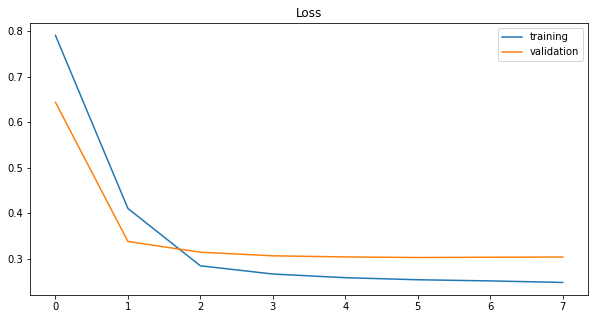

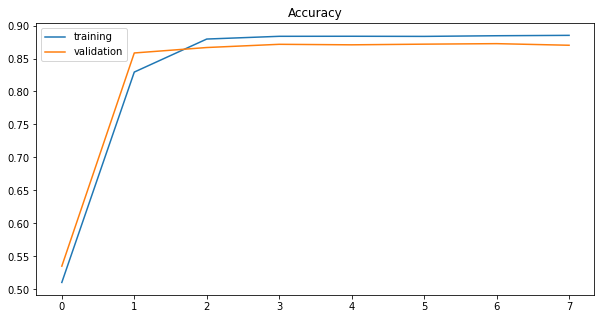


Classification report for our LSTM/GRU model


              precision    recall  f1-score   support

           0       0.84      0.91      0.88      4510
           1       0.90      0.83      0.86      4492

   micro avg       0.87      0.87      0.87      9002
   macro avg       0.87      0.87      0.87      9002
weighted avg       0.87      0.87      0.87      9002
 samples avg       0.87      0.87      0.87      9002


ROC curves for our LSTM/GRU model



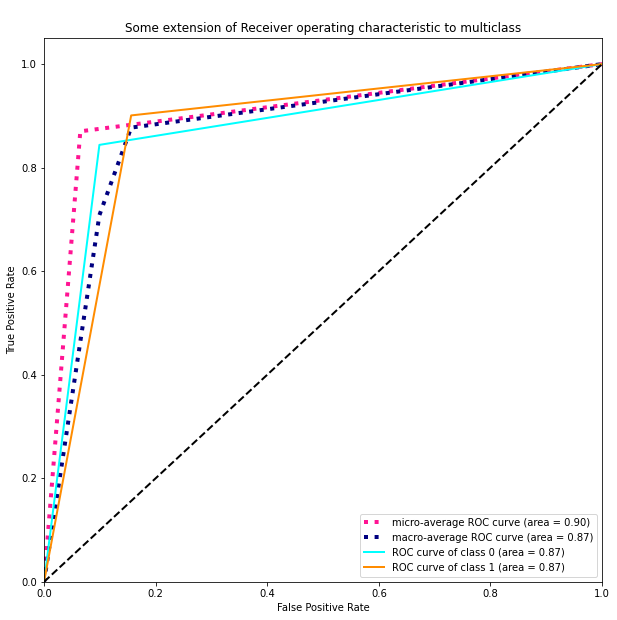

In [ ]:
########################################  .....Main Starts here.....  #########################################################


nltk.download('punkt')

device = torch.device('cuda:0' if torch.cuda.is_available()else 'cpu')

#path for csv and glove6b files

dataPath ='imdb-reviews.csv'
glove6btxtPath = 'glove.6B.100d.txt'
maxLength = 100
print('\nShould take about 3-6 minutes to complete running ...\n')

dataset = pd.read_csv(dataPath,sep='\t')
#split dataset(80% for training and 20% for testing)
trainingData = dataset.sample(frac = 0.8, random_state = 25)
validationData = dataset.drop(trainingData.index)

#get training and validation bucket iters
trainingBucketIter,validationBucketIter,review = filteringData(trainingData, validationData)

#model hyper parameters
input = len(review.vocab)
embeddingsDimension=100
hs = 256
out = 3
mType = 'LSTM' #change type to GRU
dropValue = 0.4
layers = 2
learningRate = 0.00016
embeddingsLen = 100

LSTMGRUModel =  LSTMGRUModel(input,embeddingsDimension,hs,out,mType,dropValue,layers)
LSTMGRUModel.to(device)
#define optimizer nad loss function
optimizer = torch.optim.Adam(LSTMGRUModel.parameters(),learningRate)
lossFunction =  torch.nn.CrossEntropyLoss().to(device)
#give embeddings to the model
embeddings = review.vocab.vectors
LSTMGRUModel.embedding.weight.data.copy_(embeddings)
#get indexes
unknownIndex = review.vocab.stoi[review.unk_token]
paddingIndex = review.vocab.stoi[review.pad_token]
LSTMGRUModel.embedding.weight.data[unknownIndex] = torch.zeros(embeddingsLen)
LSTMGRUModel.embedding.weight.data[paddingIndex] = torch.zeros(embeddingsLen)
#list to save loss and accuracy fdor each epoch
trainingLossEpoch = list()
trainingAccuraccyEpoch = list()
validationLossEpoch = list()
validationAccuracyEposh = list()


#for loop 8 times , traind and test our model calculate loss and epoch to check our model
for epoch in range(8):
    trainingLoss, trainAccuracy = training(LSTMGRUModel,trainingBucketIter,optimizer,lossFunction,device)
    validationLoss,validationAccuracy = validation(LSTMGRUModel,validationBucketIter,optimizer,lossFunction,device)
    trainingLossEpoch.append(np.mean(trainingLoss))
    trainingAccuraccyEpoch.append(np.mean(trainAccuracy))
    validationLossEpoch.append(np.mean(validationLoss))
    validationAccuracyEposh.append(np.mean(validationAccuracy))

plotCurves(trainingLossEpoch,trainingAccuraccyEpoch,validationLossEpoch,validationAccuracyEposh,validationBucketIter)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')